In [1]:
import torch
import json
import numpy as np
import torch.nn as nn
from scipy import stats
import matplotlib.pyplot as plt
import torch.utils.data as Data
from scipy.signal import welch

In [9]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from model.unit2 import DenoisingModelUnit2
#from model.unit3 import DenoisingModelUnit3
from model.unit4 import DenoisingModelUnit4
from DeepSeparator.network import DeepSeparator

In [10]:
import random
random.seed(42)

In [11]:
class FlowSampler:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
    
    def sample_euler(self, noisy_eeg, num_steps=1000):
        """
        Sample using Euler's method for ODE integration
        Args:
            noisy_eeg: conditioning signal [batch_size, 1, seq_len]
            num_steps: number of integration steps
        Returns:
            clean_eeg: generated clean EEG [batch_size, 1, seq_len]
        """
        # Ensure correct dtype and device
        noisy_eeg = noisy_eeg.to(self.device).float()
        batch_size, channels, seq_len = noisy_eeg.shape
        
        # Start with noise (same dtype as model)
        x = torch.randn_like(noisy_eeg, dtype=torch.float32).to(self.device)
        
        # Time step
        dt = 1.0 / num_steps
        
        with torch.no_grad():
            for i in range(num_steps):
                # Current time
                t = torch.full((batch_size,), i * dt, device=self.device, dtype=torch.float32)
                
                # Predict flow direction
                flow = self.model(x, t, noisy_eeg)
                
                # Euler step: x_{t+1} = x_t + dt * flow
                x = x + dt * flow
        
        return x

class Predictor:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
    
    def predict(self, noisy_eeg):
        noisy_eeg = noisy_eeg.to(self.device).float()
        with torch.no_grad():
            pred = self.model(noisy_eeg)
        return pred

class DeepSeparatorPredictor:
    """Custom predictor for DeepSeparator model that uses indicators"""
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
    
    def predict(self, noisy_eeg, task_type='denoise'):
        """
        Predict clean EEG from noisy input using DeepSeparator.
        task_type: 'denoise' (0), 'identity' (1), or 'artifact' (2)
        """
        noisy_eeg = noisy_eeg.to(self.device).float()
        batch_size = noisy_eeg.size(0)
        
        with torch.no_grad():
            if task_type == 'denoise':
                indicator = torch.zeros(batch_size, 1).to(self.device)
            elif task_type == 'identity':
                indicator = torch.ones(batch_size, 1).to(self.device)
            elif task_type == 'artifact':
                indicator = torch.full((batch_size, 1), 2.0).to(self.device)
            else:
                raise ValueError("task_type must be 'denoise', 'identity', or 'artifact'")
            
            pred = self.model(noisy_eeg, indicator)
        return pred

In [12]:
test_input = np.load('./eegdenoisenet/test_input.npy')
test_output = np.load('./eegdenoisenet/test_output.npy')

test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_torch_dataset = Data.TensorDataset(test_input, test_output)

test_loader = Data.DataLoader(
    dataset=test_torch_dataset,
    batch_size=1,
    shuffle=False,
)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = DenoisingModelUnit2(1, 256).to(device)
# model3 = DenoisingModelUnit3(1, 256).to(device)
model4 = DenoisingModelUnit4(1, 256, 5).to(device)
model5 = DeepSeparator().to(device)

In [ ]:
model2.load_state_dict(torch.load('checkpoints/unit2_improved/final_flow_model_256.pth')) 
# model3.load_state_dict(torch.load('checkpoints/unit3/final_flow_model_3.pth'))
model4.load_state_dict(torch.load('checkpoints/unit4_improved/final_normal_model.pth'))
model5.load_state_dict(torch.load('checkpoints/deepseparator/best_model.pth'))

<All keys matched successfully>

In [15]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps=1e-6

    def forward(self,ground_truth,prediction):
        loss=torch.mean(torch.sqrt(torch.sum(torch.square(ground_truth-prediction), dim=-1))) + self.eps
        return loss

In [16]:
criterion = RMSELoss()
sampler1 = FlowSampler(model2, device)
# sampler2 = FlowSampler(model3, device)
predictor4 = Predictor(model4, device)
predictor5 = DeepSeparatorPredictor(model5, device)


In [7]:
def evaluate_models_with_stats(test_loader, sampler1, predictor4, predictor5, criterion, device, num_samples=100):
    """
    Evaluate models and collect individual losses for statistical testing
    """
    model2_losses = []
    # model3_losses = []
    model4_losses = []
    model5_losses = [] 
    
    original_signals = []
    model2_predictions = []
    # model3_predictions = []
    model4_predictions = []
    model5_predictions = []  
    clean_signals = []
    
    print("Evaluating models...")
    
    for step, (test_input, test_output) in enumerate(test_loader):
    
        if step >= num_samples:
            break
            
        noisy_eeg = test_input
        clean_eeg = test_output.float()

        clean_eeg = clean_eeg.to(device)
        clean_eeg = clean_eeg.unsqueeze(1)

        clean_eeg_pred2 = sampler1.sample_euler(noisy_eeg.unsqueeze(1))
        # clean_eeg_pred3 = sampler2.sample_euler(noisy_eeg.unsqueeze(1))

        clean_eeg_pred4 = predictor4.predict(noisy_eeg.unsqueeze(1))

        clean_eeg_pred5 = predictor5.predict(noisy_eeg, task_type='denoise')

        loss1 = criterion(clean_eeg, clean_eeg_pred2).item()
        # loss2 = criterion(clean_eeg, clean_eeg_pred3).item()
        loss3 = criterion(clean_eeg, clean_eeg_pred4).item()
        loss4 = criterion(clean_eeg, clean_eeg_pred5).item()  

        model2_losses.append(loss1)
        # model3_losses.append(loss2)
        model4_losses.append(loss3)
        model5_losses.append(loss4)  
        
        if step < 10:
            original_signals.append(noisy_eeg.squeeze().cpu().numpy())
            clean_signals.append(clean_eeg.squeeze().cpu().numpy())
            model2_predictions.append(clean_eeg_pred2.squeeze().cpu().numpy())
            # model3_predictions.append(clean_eeg_pred3.squeeze().cpu().numpy())
            model4_predictions.append(clean_eeg_pred4.squeeze().cpu().numpy())
            model5_predictions.append(clean_eeg_pred5.cpu().numpy())

        if (step + 1) % 10 == 0:
            print(f"Processed {step + 1} samples")
    
    return {
        'losses': {
            'model2': model2_losses,
            # 'model3': model3_losses,
            'model4': model4_losses,
            'model5': model5_losses  
        },
        'signals': {
            'original': original_signals,
            'clean': clean_signals,
            'model2_pred': model2_predictions,
            # 'model3_pred': model3_predictions,
            'model4_pred': model4_predictions,
            'model5_pred': model5_predictions  
        }
    }

def perform_statistical_tests(losses_dict):
    """
    Perform paired t-tests between model performances including Model 5
    """
    model2_losses = np.array(losses_dict['model2'])
    # model3_losses = np.array(losses_dict['model3']) 
    model4_losses = np.array(losses_dict['model4'])
    model5_losses = np.array(losses_dict['model5'])  
    
    print("=== STATISTICAL TESTING RESULTS ===")
    print(f"Model 2 (Unit2) mean loss: {model2_losses.mean():.4f} ± {model2_losses.std():.4f}")
    # print(f"Model 3 (Unit3) mean loss: {model3_losses.mean():.4f} ± {model3_losses.std():.4f}")
    print(f"Model 4 (Unit4) mean loss: {model4_losses.mean():.4f} ± {model4_losses.std():.4f}")
    print(f"Model 5 (DeepSeparator) mean loss: {model5_losses.mean():.4f} ± {model5_losses.std():.4f}")
    print()
    
    # models = ['Model 2', 'Model 3', 'Model 4', 'Model 5']
    # model_losses = [model2_losses, model3_losses, model4_losses, model5_losses]

    models = ['Model 2', 'Model 4', 'Model 5']
    model_losses = [model2_losses, model4_losses, model5_losses]
    
    print("Pairwise t-test results:")
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            t_stat, p_val = stats.ttest_rel(model_losses[i], model_losses[j])
            print(f"{models[i]} vs {models[j]}:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_val:.6f}")
            print(f"  Significant at α=0.05: {'Yes' if p_val < 0.05 else 'No'}")
            print()
    
    def cohens_d(x, y):
        pooled_std = np.sqrt(((len(x) - 1) * np.var(x) + (len(y) - 1) * np.var(y)) / (len(x) + len(y) - 2))
        return (np.mean(x) - np.mean(y)) / pooled_std
    
    print("Effect sizes (Cohen's d):")
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            d = cohens_d(model_losses[i], model_losses[j])
            print(f"  {models[i]} vs {models[j]}: {d:.4f}")
    print()
    
    # Create box plot including Model 5
    plt.figure(figsize=(12, 6))
    # box = plt.boxplot([model2_losses, model3_losses, model4_losses, model5_losses], patch_artist=True)
    # plt.xticks([1, 2, 3, 4], ['Model 2\n(Unit2)', 'Model 3\n(Unit3)', 'Model 4\n(Unit4)', 'Model 5\n(DeepSeparator)'])

    box = plt.boxplot([model2_losses, model4_losses, model5_losses], patch_artist=True)
    plt.xticks([1, 2, 3], ['Unit2', 'Unit4', 'DeepSeparator'])
    plt.ylabel('RMSE Loss')
    plt.title('Model Performance Comparison')
    plt.grid(True, alpha=0.3)
    plt.show()

def analyze_power_spectrum(signals_dict, sampling_rate=256, i=0):
    """
    Analyze power spectrum of EEG signals including Model 5
    """
    print("=== POWER SPECTRUM ANALYSIS ===")
    
    original = signals_dict['original'][i]
    clean = signals_dict['clean'][i]
    model2_pred = signals_dict['model2_pred'][i]
    # model3_pred = signals_dict['model3_pred'][i]
    model4_pred = signals_dict['model4_pred'][i]
    model5_pred = signals_dict['model5_pred'][i]  

    if len(original.shape) > 1:
        original = original.squeeze()
    if len(clean.shape) > 1:
        clean = clean.squeeze()
    if len(model2_pred.shape) > 1:
        model2_pred = model2_pred.squeeze()
    # if len(model3_pred.shape) > 1:
    #     model3_pred = model3_pred.squeeze()
    if len(model4_pred.shape) > 1:
        model4_pred = model4_pred.squeeze()
    if len(model5_pred.shape) > 1:
        model5_pred = model5_pred.squeeze()
    
    freqs_orig, psd_orig = welch(original, fs=sampling_rate, nperseg=256)
    freqs_clean, psd_clean = welch(clean, fs=sampling_rate, nperseg=256)
    freqs_m2, psd_m2 = welch(model2_pred, fs=sampling_rate, nperseg=256)
    # freqs_m3, psd_m3 = welch(model3_pred, fs=sampling_rate, nperseg=256)
    freqs_m4, psd_m4 = welch(model4_pred, fs=sampling_rate, nperseg=256)
    freqs_m5, psd_m5 = welch(model5_pred, fs=sampling_rate, nperseg=256) 
    
    plt.figure(figsize=(18, 12))
    
    plt.subplot(2, 3, 1)
    time_axis = np.arange(len(original)) / sampling_rate
    plt.plot(time_axis[:1000], original[:1000], label='Noisy', alpha=0.7)
    plt.plot(time_axis[:1000], clean[:1000], label='Clean', alpha=0.7)
    plt.plot(time_axis[:1000], model5_pred[:1000], label='Model 5 Pred', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Time Domain Signals (First 4 seconds)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 2)
    plt.semilogy(freqs_orig, psd_orig, label='Noisy', alpha=0.7)
    plt.semilogy(freqs_clean, psd_clean, label='Clean (Ground Truth)', alpha=0.7, linewidth=2)
    plt.semilogy(freqs_m2, psd_m2, label='Model 2', alpha=0.7)
    # plt.semilogy(freqs_m3, psd_m3, label='Model 3', alpha=0.7)
    plt.semilogy(freqs_m4, psd_m4, label='Model 4', alpha=0.7)
    plt.semilogy(freqs_m5, psd_m5, label='Model 5 (DeepSeparator)', alpha=0.7)  
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Power Spectral Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 50)  # Focus on 0-50 Hz range
    
    plt.subplot(2, 3, 3)
    bands = {
        'Delta (0.5-4 Hz)': (0.5, 4),
        'Theta (4-8 Hz)': (4, 8),
        'Alpha (8-13 Hz)': (8, 13),
        'Beta (13-30 Hz)': (13, 30),
        'Gamma (30-50 Hz)': (30, 50)
    }
    
    def get_band_power(freqs, psd, band_range):
        idx = np.logical_and(freqs >= band_range[0], freqs <= band_range[1])
        return np.trapezoid(psd[idx], freqs[idx])
    
    band_names = list(bands.keys())
    clean_powers = [get_band_power(freqs_clean, psd_clean, bands[band]) for band in band_names]
    m2_powers = [get_band_power(freqs_m2, psd_m2, bands[band]) for band in band_names]
    # m3_powers = [get_band_power(freqs_m3, psd_m3, bands[band]) for band in band_names]
    m4_powers = [get_band_power(freqs_m4, psd_m4, bands[band]) for band in band_names]
    m5_powers = [get_band_power(freqs_m5, psd_m5, bands[band]) for band in band_names] 
    
    x = np.arange(len(band_names))
    width = 0.15
    
    plt.bar(x - 2*width, clean_powers, width, label='Clean', alpha=0.8)
    plt.bar(x - width, m2_powers, width, label='Model 2', alpha=0.8)
    # plt.bar(x, m3_powers, width, label='Model 3', alpha=0.8)
    plt.bar(x + width, m4_powers, width, label='Model 4', alpha=0.8)
    plt.bar(x + 2*width, m5_powers, width, label='Model 5', alpha=0.8)  
    
    plt.xlabel('Frequency Bands')
    plt.ylabel('Power')
    plt.title('Power in Different Frequency Bands')
    plt.xticks(x, band_names, rotation=45)
    plt.legend()
    plt.yscale('log')
    
    plt.subplot(2, 3, 4)
    correlations = {
        'Model 2 vs Clean': np.corrcoef(model2_pred, clean)[0, 1],
        # 'Model 3 vs Clean': np.corrcoef(model3_pred, clean)[0, 1],
        'Model 4 vs Clean': np.corrcoef(model4_pred, clean)[0, 1],
        'Model 5 vs Clean': np.corrcoef(model5_pred, clean)[0, 1], 
        'Noisy vs Clean': np.corrcoef(original, clean)[0, 1]
    }
    
    models = list(correlations.keys())
    corr_values = list(correlations.values())
    
    plt.bar(models, corr_values, alpha=0.8)
    plt.ylabel('Correlation with Clean Signal')
    plt.title('Signal Correlation Analysis')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    for i, v in enumerate(corr_values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.subplot(2, 3, 5)
    # model_names = ['Model 2', 'Model 3', 'Model 4', 'Model 5']
    # model_corrs = [correlations['Model 2 vs Clean'], correlations['Model 3 vs Clean'], 
    #                correlations['Model 4 vs Clean'], correlations['Model 5 vs Clean']]
    
    model_names = ['Model 2', 'Model 4', 'Model 5']
    model_corrs = [correlations['Model 2 vs Clean'], 
                   correlations['Model 4 vs Clean'], correlations['Model 5 vs Clean']]
    
    plt.bar(model_names, model_corrs, alpha=0.8, color=['blue', 'orange', 'green', 'red'])
    plt.ylabel('Correlation with Clean Signal')
    plt.title('Model Performance Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    
    for i, v in enumerate(model_corrs):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print(f"Signal correlations with clean EEG:")
    for model, corr in correlations.items():
        print(f"  {model}: {corr:.4f}")
    
    print(f"\nFrequency band power ratios (relative to clean signal):")
    for i, band in enumerate(band_names):
        print(f"  {band}:")
        print(f"    Model 2: {m2_powers[i]/clean_powers[i]:.3f}")
        # print(f"    Model 3: {m3_powers[i]/clean_powers[i]:.3f}")
        print(f"    Model 4: {m4_powers[i]/clean_powers[i]:.3f}")
        print(f"    Model 5: {m5_powers[i]/clean_powers[i]:.3f}") 

In [18]:
results = evaluate_models_with_stats(test_loader, sampler1, predictor4, predictor5, criterion, device, num_samples=1500)

Evaluating models...
Processed 10 samples
Processed 20 samples
Processed 30 samples
Processed 40 samples
Processed 50 samples
Processed 60 samples
Processed 70 samples
Processed 80 samples
Processed 90 samples
Processed 100 samples
Processed 110 samples
Processed 120 samples
Processed 130 samples
Processed 140 samples
Processed 150 samples
Processed 160 samples
Processed 170 samples
Processed 180 samples
Processed 190 samples
Processed 200 samples
Processed 210 samples
Processed 220 samples
Processed 230 samples
Processed 240 samples
Processed 250 samples
Processed 260 samples
Processed 270 samples
Processed 280 samples
Processed 290 samples
Processed 300 samples
Processed 310 samples
Processed 320 samples
Processed 330 samples
Processed 340 samples
Processed 350 samples
Processed 360 samples
Processed 370 samples
Processed 380 samples
Processed 390 samples
Processed 400 samples
Processed 410 samples
Processed 420 samples
Processed 430 samples
Processed 440 samples
Processed 450 sample

In [ ]:

def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: numpy_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(v) for v in obj]
    else:
        return obj

def list_to_numpy(obj):
    if isinstance(obj, list):
        try:
            arr = np.array(obj)
            if arr.dtype != object:
                return arr
        except Exception:
            pass
        return [list_to_numpy(v) for v in obj]
    elif isinstance(obj, dict):
        return {k: list_to_numpy(v) for k, v in obj.items()}
    else:
        return obj

## Convert results for saving
results_serializable = numpy_to_list(results)

with open('results.json', 'w') as f:
    json.dump(results_serializable, f, indent=2)

In [4]:
# To revert after loading:
with open('results.json', 'r') as f:
    loaded = json.load(f)

loaded_results = list_to_numpy(loaded)

In [21]:
# for i in range(1):
#     analyze_power_spectrum(loaded_results['signals'], sampling_rate=256, i=i)

In [5]:
model2_corr_list = []
# model3_corr_list = []
model4_corr_list = []
model5_corr_list = []

# Dictionary to store band lists for each model
band_lists = {
    'model2': {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'gamma': []},
    # 'model3': {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'gamma': []},
    'model4': {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'gamma': []},
    'model5': {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'gamma': []}
}

sampling_rate = 256

bands = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-50 Hz)': (30, 50)
}

def get_band_power(freqs, psd, band_range):
    if len(psd.shape) > 1:
        psd = psd.flatten()
    try:
        idx = np.logical_and(freqs >= band_range[0], freqs <= band_range[1])
        if not np.any(idx):
            return 0.0
        return np.trapezoid(psd[idx], freqs[idx])
    except Exception:
        return 0.0

def calculate_power_ratio(pred_powers, clean_powers):
    return [p/c if c != 0 else 0.0 for p, c in zip(pred_powers, clean_powers)]

for i in range(len(loaded_results['signals']['original'])):
    # Get signals
    original = loaded_results['signals']['original'][i]
    clean = loaded_results['signals']['clean'][i]
    predictions = {
        'model2': loaded_results['signals']['model2_pred'][i],
        # 'model3': loaded_results['signals']['model3_pred'][i],
        'model4': loaded_results['signals']['model4_pred'][i],
        'model5': loaded_results['signals']['model5_pred'][i]
    }
    
    # Calculate correlations
    corr_lists = {
        'model2': model2_corr_list,
        # 'model3': model3_corr_list,
        'model4': model4_corr_list,
        'model5': model5_corr_list
    }
    
    for model_name, pred in predictions.items():
        corr = np.corrcoef(pred, clean)[0, 1]
        corr_lists[model_name].append(corr)
    
    # Calculate PSDs
    freqs_clean, psd_clean = welch(clean, fs=sampling_rate, nperseg=256)
    psds = {model: welch(pred, fs=sampling_rate, nperseg=256) 
            for model, pred in predictions.items()}
    
    # Calculate powers for each band
    clean_powers = [get_band_power(freqs_clean, psd_clean, bands[band]) 
                   for band in bands]
    
    # Calculate power ratios for each model
    for model_name, (freqs, psd) in psds.items():
        model_powers = [get_band_power(freqs, psd, bands[band]) for band in bands]
        ratios = calculate_power_ratio(model_powers, clean_powers)
        
        # Store ratios in appropriate lists
        for band_idx, band_name in enumerate(bands.keys()):
            band_type = band_name.split()[0].lower()
            band_lists[model_name][band_type].append(ratios[band_idx])

=== STATISTICAL TESTING RESULTS ===
Model 2 (Unit2) mean loss: 5.2993 ± 1.8081
Model 4 (Unit4) mean loss: 4.3354 ± 1.1934
Model 5 (DeepSeparator) mean loss: 4.5264 ± 1.0353

Pairwise t-test results:
Model 2 vs Model 4:
  t-statistic: 24.3626
  p-value: 0.000000
  Significant at α=0.05: Yes

Model 2 vs Model 5:
  t-statistic: 19.1666
  p-value: 0.000000
  Significant at α=0.05: Yes

Model 4 vs Model 5:
  t-statistic: -7.0891
  p-value: 0.000000
  Significant at α=0.05: Yes

Effect sizes (Cohen's d):
  Model 2 vs Model 4: 0.6292
  Model 2 vs Model 5: 0.5246
  Model 4 vs Model 5: -0.1710



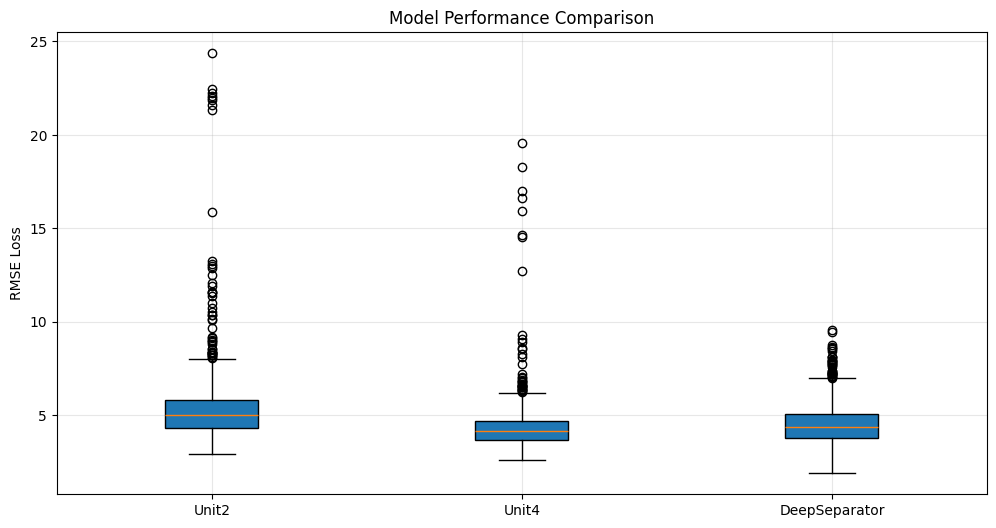

In [8]:
perform_statistical_tests(loaded_results['losses'])

In [9]:
print("=== AVERAGE SIGNAL CORRELATIONS ===")
print(f"Model 2 (Unit2) average correlation: {np.mean(model2_corr_list):.4f} ± {np.std(model2_corr_list):.4f}")
# print(f"Model 3 (Unit3) average correlation: {np.mean(model3_corr_list):.4f} ± {np.std(model3_corr_list):.4f}")
print(f"Model 4 (Unit4) average correlation: {np.mean(model4_corr_list):.4f} ± {np.std(model4_corr_list):.4f}")
print(f"Model 5 (DeepSeparator) average correlation: {np.mean(model5_corr_list):.4f} ± {np.std(model5_corr_list):.4f}")

# Perform t-tests between correlations of different models
print("=== T-TEST RESULTS FOR CORRELATIONS ===")

# Convert lists to numpy arrays for easier calculations
model2_corr = np.array(model2_corr_list)
# model3_corr = np.array(model3_corr_list)
model4_corr = np.array(model4_corr_list)
model5_corr = np.array(model5_corr_list)

# Perform paired t-tests between all model pairs
# models = ['Model 2', 'Model 3', 'Model 4', 'Model 5']
# corr_arrays = [model2_corr, model3_corr, model4_corr, model5_corr]

models = ['Model 2', 'Model 4', 'Model 5']
corr_arrays = [model2_corr, model4_corr, model5_corr]

for i in range(len(models)):
    for j in range(i+1, len(models)):
        t_stat, p_val = stats.ttest_rel(corr_arrays[i], corr_arrays[j])
        print(f"{models[i]} vs {models[j]}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_val:.6f}")
        print(f"  Significant at α=0.05: {'Yes' if p_val < 0.05 else 'No'}")
        print()

# Effect sizes (Cohen's d)
def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x) - 1) * np.var(x) + (len(y) - 1) * np.var(y)) / (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

print("Effect sizes (Cohen's d):")
for i in range(len(models)):
    for j in range(i+1, len(models)):
        d = cohens_d(corr_arrays[i], corr_arrays[j])
        print(f"  {models[i]} vs {models[j]}: {d:.4f}")

=== AVERAGE SIGNAL CORRELATIONS ===
Model 2 (Unit2) average correlation: 0.5534 ± 0.0997
Model 4 (Unit4) average correlation: 0.7155 ± 0.0736
Model 5 (DeepSeparator) average correlation: 0.7158 ± 0.0708
=== T-TEST RESULTS FOR CORRELATIONS ===
Model 2 vs Model 4:
  t-statistic: -8.8560
  p-value: 0.000010
  Significant at α=0.05: Yes

Model 2 vs Model 5:
  t-statistic: -9.2545
  p-value: 0.000007
  Significant at α=0.05: Yes

Model 4 vs Model 5:
  t-statistic: -0.0159
  p-value: 0.987697
  Significant at α=0.05: No

Effect sizes (Cohen's d):
  Model 2 vs Model 4: -1.8507
  Model 2 vs Model 5: -1.8783
  Model 4 vs Model 5: -0.0035


In [10]:
# Define band names for clear output
band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
# model_names = ['Model 2', 'Model 3', 'Model 4', 'Model 5']
model_names = ['Model 2', 'Model 4', 'Model 5']

# Calculate statistics for each band and model
print("=== Average Frequency Band Power Ratio Statistics ===")
print("(Power ratios relative to clean signal)\n")

for band in band_names:
    print(f"{band.capitalize()} band:")
    # for model_name, model_key in zip(model_names, ['model2', 'model3', 'model4', 'model5']):
    for model_name, model_key in zip(model_names, ['model2', 'model4', 'model5']):
        band_data = np.array(band_lists[model_key][band])
        mean = np.mean(band_data)
        std = np.std(band_data)
        print(f"  {model_name}: {mean:.4f} ± {std:.4f}")
    print()

=== Average Frequency Band Power Ratio Statistics ===
(Power ratios relative to clean signal)

Delta band:
  Model 2: 1.0227 ± 0.6290
  Model 4: 0.2882 ± 0.0997
  Model 5: 0.8108 ± 0.3406

Theta band:
  Model 2: 1.6803 ± 0.7443
  Model 4: 0.5235 ± 0.1512
  Model 5: 1.5057 ± 0.4009

Alpha band:
  Model 2: 0.8880 ± 0.2248
  Model 4: 0.7125 ± 0.1173
  Model 5: 0.8545 ± 0.1396

Beta band:
  Model 2: 1.1448 ± 0.2972
  Model 4: 1.5188 ± 0.3279
  Model 5: 1.1807 ± 0.2145

Gamma band:
  Model 2: 1.1156 ± 0.2849
  Model 4: 1.1019 ± 0.2553
  Model 5: 1.1267 ± 0.3670

